In [92]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fakeInjectionPipeline as fip
from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog
import data_process_utils as dpu

In [86]:
def make_injection_repo(repo_path):
    COADD_REPO = ('/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i'
                  '/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy')
    os.makedirs(repo_path)
    calexp_path = os.path.join(repo_path, 'calexp')
    os.makedirs(calexp_path)
    yaml_path = os.path.join(repo_path, 'repositoryCfg.yaml')
    with open(f'{yaml_path}', "w+") as file:
        file.write("!RepositoryCfg_v1\n")
        file.write("_mapper: !!python/name:lsst.obs.lsst.imsim.ImsimMapper \'\'\n")
        file.write("_mapperArgs: {}\n")
        file.write("_parents:\n")
        file.write(f"- {COADD_REPO}\n")
        file.write("_policy: null\n")
        file.write("_root: null\n")
        file.write("dirty: true\n")

def cal_flux(photoCalib, x, y, mag):
    xy = geom.Point2D(x, y)
    flux = photoCalib.magnitudeToInstFlux(magVar, xy)
    return flux
    
def inject_star(exposure, flux, x, y, negative_flux=False): 
    exposure.mask.addMaskPlane("FAKE")
    bitmask = exposure.mask.getPlaneBitMask("FAKE")
    xy = geom.Point2D(x, y)
    psf = exposure.getPsf()
    starIm = psf.computeImage(xy)
    calibFluxRadius = 12
    correctedFlux = psf.computeApertureFlux(calibFluxRadius, xy)
    starIm /= correctedFlux
    starIm *= flux
    star_shape = starIm.array.shape
    star_array = starIm.getArray()
    star_array[star_array < 1e-19] = 0.
    if negative_flux:
        star_array *= (-1)

    fakeImage = starIm.convertF()
    imageBBox = exposure.getBBox()
    imageMI = exposure.maskedImage

    interpFakeImage = fakeImage
    interpFakeImBBox = fakeImage.getBBox()
    interpFakeImBBox.clip(imageBBox)
    imageMIView = imageMI.Factory(imageMI, interpFakeImBBox)

    if interpFakeImBBox.getArea() > 0:
        clippedFakeImage = interpFakeImage.Factory(interpFakeImage, interpFakeImBBox)
        clippedFakeImageMI = afwImage.MaskedImageF(clippedFakeImage)
        clippedFakeImageMI.mask.set(bitmask)
        imageMIView += clippedFakeImageMI

In [91]:
"""
pos_repo = './data/negative_injections/pos/'
neg_repo = './data/negative_injections/neg/'
make_injection_repo(pos_repo)
make_injection_repo(neg_repo)
""";

In [88]:
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list=['00'], host_mag_list= ['20_21'],
    dbpath= './data/table/gal_4639/injection_coord.sqlite')
coord_arr = injection_coord_dict['00_20_21_1013665_79_i']
calexp_id = {'visit': 1013665, 'detector': 79, 'filter': 'i'}
magVar = 16

In [89]:
calexp_butler = Butler(pos_repo)
calexp_photoCalib = calexp_butler.get('calexp_photoCalib',  calexp_id)
calexp_exposure = calexp_butler.get('calexp', dataId=calexp_id)
for coord in coord_arr:
    x, y = coord[0], coord[1]
    flux = cal_flux(calexp_photoCalib, x, y, magVar)
    inject_star(calexp_exposure, flux, x, y, negative_flux=False)
calexp_butler.put(calexp_exposure, 'calexp', dataId=calexp_id)

In [55]:
'''
imageDifferenceDriver.py ./data/negative_injections/pos \
    --output ./data/negative_injections/pos_diff \
    --id visit=1013665 detector=79  -C diffimConfig_al.py \
    --clobber-config --clobber-versions --cores 4
''';

In [90]:
calexp_butler = Butler(neg_repo)
calexp_photoCalib = calexp_butler.get('calexp_photoCalib',  calexp_id)
calexp_exposure = calexp_butler.get('calexp', dataId=calexp_id)

for coord in coord_arr:
    x, y = coord[0], coord[1]
    flux = cal_flux(calexp_photoCalib, x, y, magVar)
    inject_star(calexp_exposure, flux, x, y, negative_flux=True)
calexp_butler.put(calexp_exposure, 'calexp', dataId=calexp_id)

In [56]:
'''
imageDifferenceDriver.py ./data/negative_injections/neg \
    --output ./data/negative_injections/neg_diff \
    --id visit=1013665 detector=79  -C diffimConfig_al.py \
    --clobber-config --clobber-versions --cores 4
''';

In [94]:
pos_exp = afwImage.ExposureF('./data/negative_injections/pos_diff/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
pos_diaSrc = BaseCatalog.readFits('./data/negative_injections/pos_diff/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
pos_diaSrc = pos_diaSrc.asAstropy()
neg_exp = afwImage.ExposureF('./data/negative_injections/neg_diff/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
neg_diaSrc = BaseCatalog.readFits('./data/negative_injections/neg_diff/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
neg_diaSrc = neg_diaSrc.asAstropy()

In [95]:
pos_xy = []
for row in pos_diaSrc:
    x, y = row['base_NaiveCentroid_x', 'base_NaiveCentroid_y']
    pos_xy.append([x, y])
neg_xy = []
for row in pos_diaSrc:
    x, y = row['base_NaiveCentroid_x', 'base_NaiveCentroid_y']
    neg_xy.append([x, y])

In [96]:
pos_matched_status, pos_matched_id = dpu.two_direction_match(coord_arr, pos_xy, radius=4)
neg_matched_status, neg_matched_id = dpu.two_direction_match(coord_arr, neg_xy, radius=4)
print(np.sum(pos_matched_status), np.sum(neg_matched_status))

19 19


In [120]:
from matplotlib.patches import Circle

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [127]:
def display_artifacts(diff_exp, diaSrc, flag='base_SdssShape_flag'):
    fig, ax = plt.subplots(4, 5, figsize=(10,5))
    ax_ls = ax.flat
    fig.subplots_adjust(hspace=0.5)
    for idx, row in enumerate(diaSrc):
        x = row['base_NaiveCentroid_x']
        y = row['base_NaiveCentroid_y']
        flag_status = row[flag]
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax_ls[idx].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax_ls[idx].set_xticks([])
        ax_ls[idx].set_xticks([])
        ax_ls[idx].set_yticks([])
        ax_ls[idx].set_yticks([])
        ax_ls[idx].set_title(str(flag_status))

In [113]:
"""
for col in pos_diaSrc.columns:
    print(col)
""";

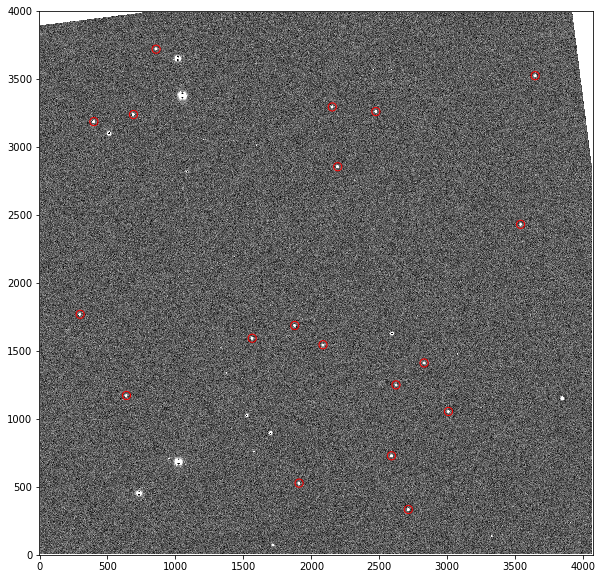

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(interval(pos_exp.getImage().array), origin='lower', cmap='gray')
for coord in coord_arr:
    circ = Circle(coord, radius=30, fill=False, color='r' )
    ax.add_patch(circ)

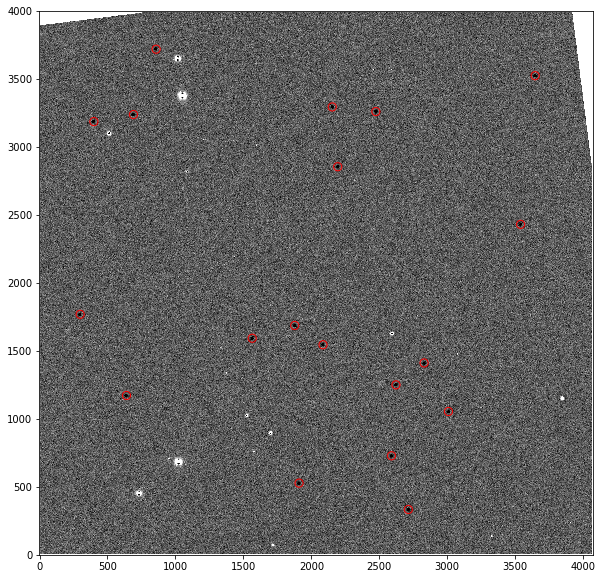

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(interval(neg_exp.getImage().array), origin='lower', cmap='gray')
for coord in coord_arr:
    circ = Circle(coord, radius=30, fill=False, color='r' )
    ax.add_patch(circ)

#### flag='base_SdssShape_flag'

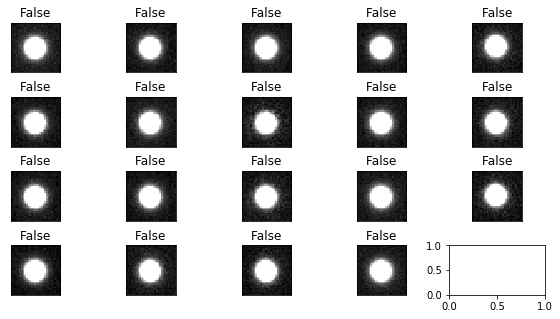

In [129]:
display_artifacts(pos_exp, pos_diaSrc[neg_matched_id], flag='base_SdssShape_flag')

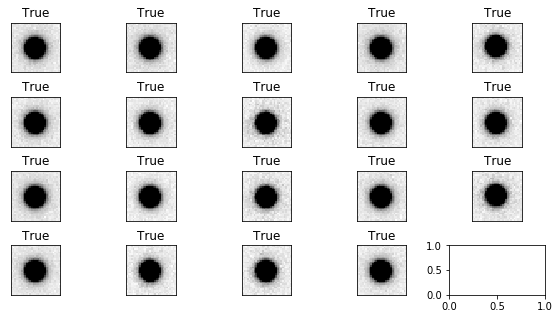

In [130]:
display_artifacts(neg_exp, neg_diaSrc[neg_matched_id], flag='base_SdssShape_flag')

#### base_SdssShape_flag_unweightedBad

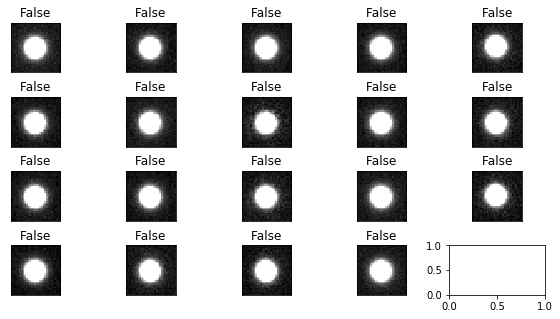

In [131]:
display_artifacts(pos_exp, pos_diaSrc[neg_matched_id], flag='base_SdssShape_flag_unweightedBad')

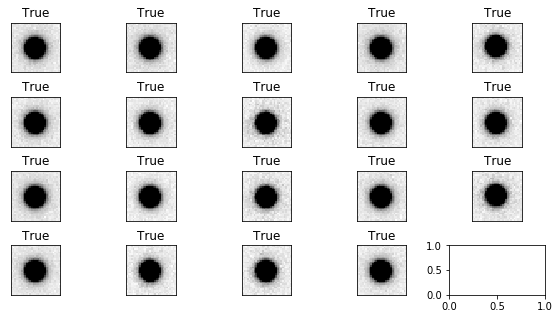

In [132]:
display_artifacts(neg_exp, neg_diaSrc[neg_matched_id], flag='base_SdssShape_flag_unweightedBad')

In [114]:
"""
base_SdssShape_flag
base_GaussianFlux_flag_badShape
slot_Shape_flag
base_SdssShape_flag_unweightedBad
base_GaussianFlux_flag_badShape_unweightedBad
slot_Shape_flag_unweightedBad
base_SdssShape_flag_unweighted
base_GaussianFlux_flag_badShape_unweighted
slot_Shape_flag_unweighted
base_SdssShape_flag_shift
base_GaussianFlux_flag_badShape_shift
slot_Shape_flag_shift
base_SdssShape_flag_maxIter
base_GaussianFlux_flag_badShape_maxIter
slot_Shape_flag_maxIter
base_SdssShape_flag_psf
base_GaussianFlux_flag_badShape_psf
slot_Shape_flag_psf
""";